In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

c:\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
data = sm.datasets.co2.load_pandas()
y = data.data


## Pre-Process Data

1. make the conversion with the resample function. Resample weekly data to monthly by taking the mean of all the values in it. http://benalexkeen.com/resampling-time-series-data-with-pandas/

2. use the fillna() function to ensure that we have no missing values in our time series.
3. bfill() - use NEXT valid observation to fill gap

In [16]:
y = y['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing values
y = y.fillna(method= 'bfill')

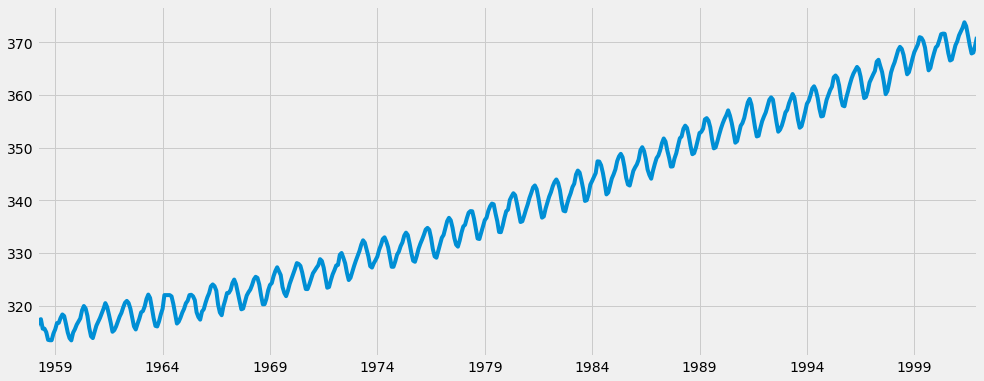

In [18]:
y.plot(figsize=(15, 6))
plt.show()

Note-
* Seasonality pattern
* Increasing trend

## The ARIMA Time Series Model
stands for Auto Regressive Integrated Moving Average.
There are three distinct integers $(p, d, q)$ that are used to parametrize ARIMA models. Together these three parameters account for seasonality, trend, and noise in datasets:
- p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

**Seasonal ARIMA**, *ARIMA(p,d,q)(P,D,Q)*. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. 

**Tuning Parameters**
We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [19]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


*Metric*-  AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624045498
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641307
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878500246952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912894922
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755126321
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327375734
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067330986
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.417471690003
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1082.2618354804601
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.431571168119
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893630987
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988165787
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194062
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.79385490535475
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759055394
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283760499742
A

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.



## Fitting an ARIMA Time Series Model
Analyse the particular model in depth

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model. We don't reject the null hypothesis and the